# Project Title
### Data Engineering Capstone Project

#### Project Summary
In this project we will create a data warehouse then build and configure Apache Airflow to automate and monitor data warehouse ETL pipelines. We will be using **I94 Immigration Data**, **World Temperature Data**, **US Demographic Data**, and **Airport Codes Data** to allow users to make queries to answer the following questions:
- countries where most immigratnts are coming from and which state they are headed to
- relationship between citizenship of the immigrant and the temperature of the destination state
- relationship between citizenship of the immigrant and the demographics of the destination state
- what types of ports are immigrants utilizing the most

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [1]:
# Do all imports and installs here
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import numpy as np

### Step 1: Scope the Project and Gather Data

#### Scope 
We will first load and explore the data in pandas to understand the datasets before proceeding to creating a dataware house in Redshift.

For the data warehouse we will create an ETL which will load the data from an **Amazon S3** bucket (parquet and csv files) and will create staging tables in **Amazon Redshift**. From there we will be executing SQL statements to create the fact and dimension tables in Redshift based on star schema. Fact table of this schema will comprise of statistics on immigration, whereas dimension tables will include visitor information, date, state information and port information

In the end wel will build and configure an **Apache Airflow** to schedule daily ETL jobs to populate data warehouse on Redshift.

#### Describe and Gather Data 

**I94 Immigration Data:** 

This data comes from the US National Tourism and Trade Office. A data dictionary is included also in the workspace. [This](https://travel.trade.gov/research/reports/i94/historical/2016.html) is where the data comes from. 
The dataset includes international visitor arrival statistics by world regions and select countries (including top 20), type of visa, mode of transportation, age groups, states visited (first intended address only), and the top ports of entry (for select countries)

**Airport Code Data:**

This is a simple table of airport codes and corresponding cities. More information [here](https://datahub.io/core/airport-codes#data) 

**World Temperature Data:**

This dataset came from Kaggle. More information [here](https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data)

**U.S. Demographic Data:**

This data comes from OpenSoft. More information [here](https://public.opendatasoft.com/explore/dataset/us-cities-demographics/export/)


## <span style="color:green"> **I94 Immigration Data**
    
This data comes from the US National Tourism and Trade Office. A data dictionary is included also in the workspace. [This](https://travel.trade.gov/research/reports/i94/historical/2016.html) is where the data comes from. 
The dataset includes international visitor arrival statistics by world regions and select countries (including top 20), type of visa, mode of transportation, age groups, states visited (first intended address only), and the top ports of entry (for select countries)

### Data Dictionary
| Feature |	Description |
| --- | --- |
| CICID |Unique record ID |
|I94YR	|4 digit year|
|I94MON	|Numeric month|
|I94CIT	|3 digit Citizenship Country Code|
|I94RES	|3 digit Residence Country Code|
|I94PORT |	Port addmitted through|
|ARRDATE|	Arrival date in the USA|
|I94MODE|	Mode of transportation (1 = Air; 2 = Sea; 3 = Land; 9 = Not reported)|
|I94ADDR|	US State of arrival|
|DEPDATE|	Departure date from US|
|I94BIR	|Age of Respondent in Years|
|I94VISA|	Visa codes collapsed into three categories: (1 = Business; 2 = Pleasure; 3 = Student)|
|COUNT	|Field used for summary statistics|
|DTADFILE|	Character Date Field|
|VISAPOST|	Department of State where where Visa was issued|
|OCCUP	|Occupation that will be performed in U.S.|
|ENTDEPA|	Arrival Flag. Whether admitted or paroled into the US|
|ENTDEPD|	Departure Flag. Whether departed, lost visa, or deceased|
|ENTDEPU|	Update Flag. Update of visa, either apprehended, overstayed, or updated to PR|
|MATFLAG|	Match flag|
|BIRYEAR|	4 digit year of birth|
|DTADDTO|	Character date field to when admitted in the US|
|GENDER	|Gender|
|INSNUM	|INS number|
|AIRLINE|	Airline used to arrive in U.S.|
|ADMNUM	|Admission number, should be unique and not nullable|
|FLTNO	|Flight number of Airline used to arrive in U.S.|
|VISATYPE|	Class of admission legally admitting the non-immigrant to temporarily stay in U.S.|

### Load I94 Immigration Dataset

In [2]:
# List all immigration data files
imm_files=glob.glob('Data/sas_data/*parquet')

# Read all the files into a DataFrame
df_imm=pd.DataFrame()
for files in imm_files[:]:
    df_imm = df_imm.append(pd.read_parquet(files, engine='pyarrow'))
    
print('Number of Rows: ', len(df_imm))

df_imm.head()

Number of Rows:  3096313


,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,1360825.0,2016.0,4.0,117.0,117.0,NYC,20552.0,1.0,NY,20556.0,...,None,M,1950.0,07062016,None,None,DL,5.582890e+10,00475,WT
1,1360826.0,2016.0,4.0,117.0,117.0,NYC,20552.0,1.0,NY,20556.0,...,None,M,1953.0,07062016,None,None,DL,5.582914e+10,00475,WT
2,1360827.0,2016.0,4.0,117.0,117.0,NYC,20552.0,1.0,NY,20556.0,...,None,M,1969.0,07062016,None,None,EK,5.583591e+10,00205,WT
3,1360828.0,2016.0,4.0,117.0,117.0,NYC,20552.0,1.0,NY,20556.0,...,None,M,1972.0,07062016,None,None,AA,5.580522e+10,00199,WT
4,1360829.0,2016.0,4.0,117.0,117.0,NYC,20552.0,1.0,NY,20556.0,...,None,M,1974.0,07062016,M,None,JJ,7.185010e+08,8078,WT


## <span style="color:green"> **Airport Code Data**
    
This is a simple table of airport codes and corresponding cities. More information [here](https://datahub.io/core/airport-codes#data) 

### Data Dictionary

| Features |	Description |
| --- | --- |
ident|	Unique identifier
type|	Type of the airport
name|	Airport Name
elevation_ft|	Altitude of the airport
continent|	Continent
iso_country	|ISO code of the country of the airport
iso_region	|ISO code for the region of the airport
municipality|	City where the airport is located
gps_code	|GPS code of the airport
iata_code	|IATA code of the airport
local_code	|Local code of the airport
coordinates|	GPS coordinates of the airport

### Load Airport Code Data

In [3]:
# Airport Codes
df_airport = pd.read_csv('Data/airport-codes_csv.csv')

print('Number of Rows: ', len(df_airport))
df_airport.head(5)

Number of Rows:  57394


,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,US-AR,Newport,NaN,NaN,NaN,"-91.254898, 35.6087"


## <span style="color:green"> World Temperature Data

This dataset came from Kaggle. More information [here](https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data)

### Data Dictionary
| Feature|	Description |
| --- | --- |
dt|	Date in format YYYY-MM-DD
AverageTemperature|	Average temperature of the city in a given date
AverageTemperature	|Uncertainity in Temperature measurement
State | State for which the temperature is reported
Country	|Country Name

### Load World Temperatures Data

In [4]:
# Global Temperatures
df_temp = pd.read_csv('Data/GlobalLandTemperaturesByState.csv')

print('Number of Rows: ', len(df_temp))
df_temp.head(5)

Number of Rows:  645675


,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
0,1855-05-01,25.544,1.171,Acre,Brazil
1,1855-06-01,24.228,1.103,Acre,Brazil
2,1855-07-01,24.371,1.044,Acre,Brazil
3,1855-08-01,25.427,1.073,Acre,Brazil
4,1855-09-01,25.675,1.014,Acre,Brazil


## <span style="color:green"> US Demographics Data
    
This data comes from OpenSoft. More information [here](https://public.opendatasoft.com/explore/dataset/us-cities-demographics/export/)

### Data Dictionary
| Feature |	Description |
| --- | --- |
City	|Name of the city
State|	US state of the city
Median Age|	The median of the age of the population
Male Population	|Number of the male population
Female Population|	Number of the female population
Total Population|	Number of the total population
Number of Veterans	|Number of veterans living in the city
Foreign-born|	Number of residents of the city that were not born in the city
Average Household Size|	Average size of the houses in the city
State Code	|Code of the state of the city
Race	|Race class
Count	|Number of individual of each race

### Load US Demographics Data

In [5]:
# City Demographics
df_dem = pd.read_csv('Data/us-cities-demographics.csv',sep=';')

print('Number of Rows: ', len(df_dem))
df_dem.head(5)

Number of Rows:  2891


,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Framingham,Massachusetts,40.3,35442.0,35768.0,71210,2625.0,19070.0,2.49,MA,Black or African-American,6944
1,Waco,Texas,29.3,63452.0,68890.0,132342,10716.0,14235.0,2.57,TX,Asian,4230
2,Fort Worth,Texas,32.6,414126.0,422843.0,836969,39182.0,143404.0,2.88,TX,American Indian and Alaska Native,7504
3,Bellingham,Washington,30.7,41286.0,43857.0,85143,4703.0,8713.0,2.44,WA,American Indian and Alaska Native,2056
4,Maple Grove,Minnesota,38.6,31780.0,36601.0,68381,2943.0,7645.0,2.64,MN,White,59683


## <span style="color:green"> Other Dictionary Data
    
This is the dictionary data which comes as part of I94 Immigration dataset

In [6]:
# Load Additional Dictionary Data such as Airport codes and City Codes data
df_airport_codes = pd.read_csv('Data/i94_airport_codes.csv')
df_city_codes = pd.read_csv('Data/i94_Country_Codes.csv',sep=';')

display(df_airport_codes.head(2), df_city_codes.head(2))

,port,port_name,state
0,ALC,ALCAN,AK
1,ANC,ANCHORAGE,AK


,582,"MEXICOAirSea,andNotReported(I-94,nolandarrivals)"
0,236,AFGHANISTAN
1,101,ALBANIA


### Step 2: Explore and Assess the Data
#### Explore the Data 
Identify data quality issues, like missing values, duplicate data, etc.

#### Plot Missing Values for all tables

<AxesSubplot:>

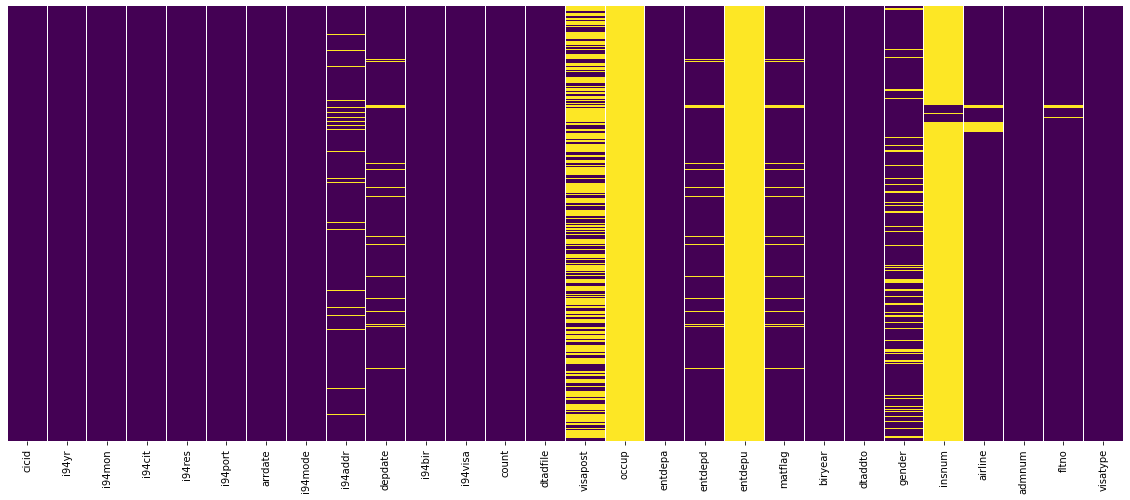

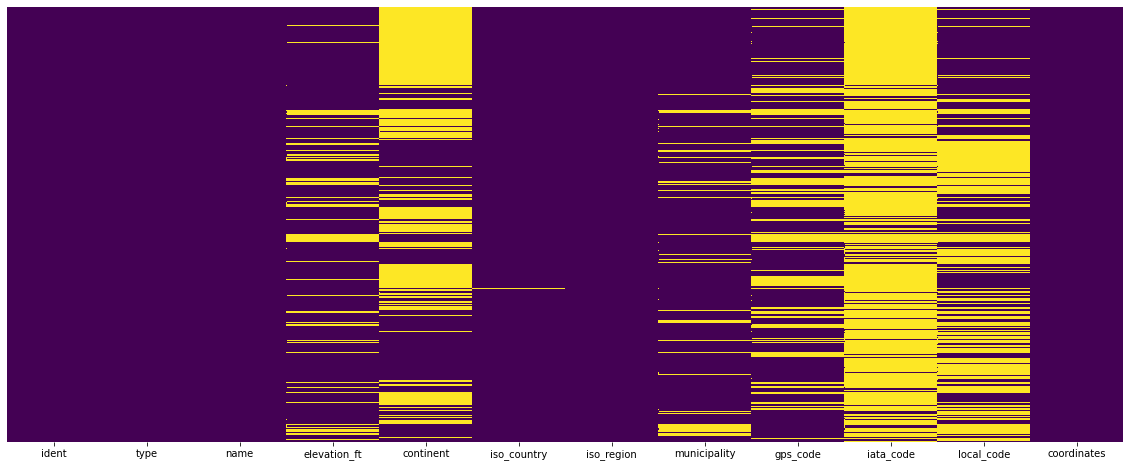

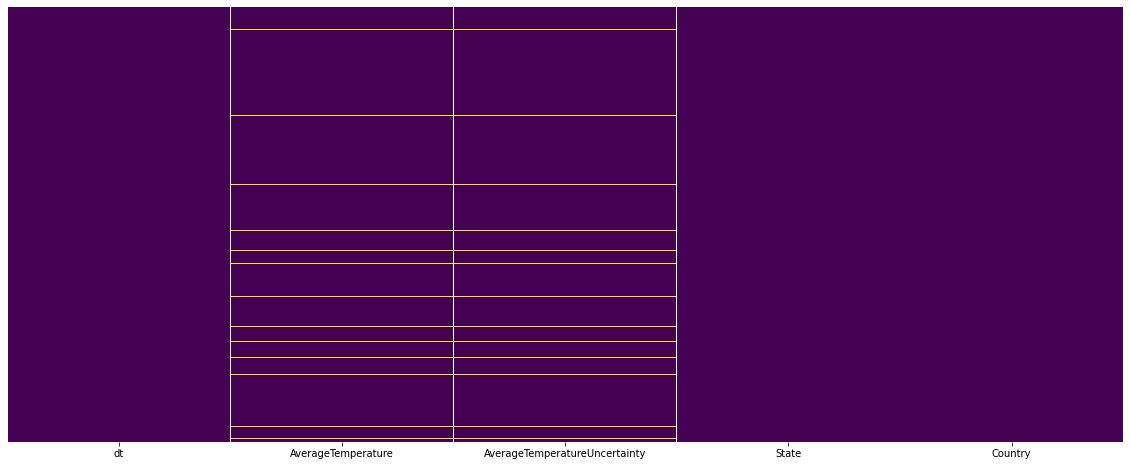

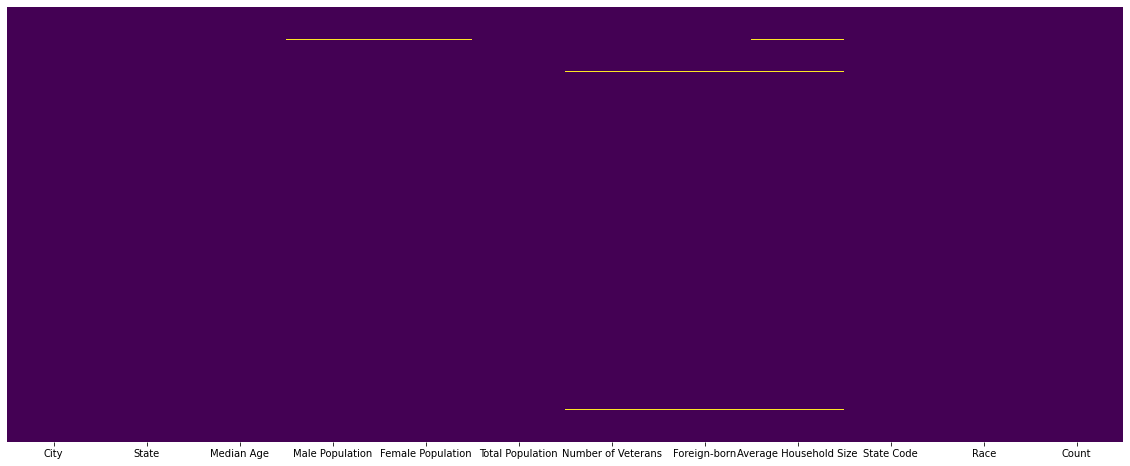

In [7]:
plt.figure(figsize=(20,8))
sns.heatmap(data=df_imm.isnull(),cmap='viridis',yticklabels=False,cbar=False)

plt.figure(figsize=(20,8))
sns.heatmap(data=df_airport.isnull(),cmap='viridis',yticklabels=False,cbar=False)

plt.figure(figsize=(20,8))
sns.heatmap(data=df_temp.isnull(),cmap='viridis',yticklabels=False,cbar=False)

plt.figure(figsize=(20,8))
sns.heatmap(data=df_dem.isnull(),cmap='viridis',yticklabels=False,cbar=False)

#### Cleaning Steps

#### Identify Columns with highest percentage of missing data and exclude the columns with more than 50% of missing data from further analysis

In [8]:
# Define a Function to calculate missing values percentage
def missing_values(df):
    missing_data_stats=pd.DataFrame(df.isnull().sum(),columns=['Missing_Values'])
    missing_data_stats['Missing_Percentage']=(missing_data_stats['Missing_Values']/len(df))*100
    return missing_data_stats.sort_values(by='Missing_Percentage', ascending = False)

In [9]:
# Immigration Data
missing_values(df_imm)

,Missing_Values,Missing_Percentage
entdepu,3095921,99.987340
occup,3088187,99.737559
insnum,2982605,96.327632
visapost,1881250,60.757746
gender,414269,13.379429
i94addr,152592,4.928184
depdate,142457,4.600859
matflag,138429,4.470769
entdepd,138429,4.470769
airline,83627,2.700857


In [10]:
# Airport Data
missing_values(df_airport)

,Missing_Values,Missing_Percentage
iata_code,48167,83.923407
continent,28443,49.557445
local_code,27429,47.790710
gps_code,15859,27.631808
elevation_ft,7814,13.614664
municipality,5893,10.267624
iso_country,246,0.428616
ident,0,0.000000
type,0,0.000000
name,0,0.000000


In [11]:
# World Temp Data
missing_values(df_temp)

,Missing_Values,Missing_Percentage
AverageTemperature,25648,3.972277
AverageTemperatureUncertainty,25648,3.972277
dt,0,0.000000
State,0,0.000000
Country,0,0.000000


In [12]:
# US Demographics Data
missing_values(df_dem)

,Missing_Values,Missing_Percentage
Average Household Size,16,0.553442
Number of Veterans,13,0.449671
Foreign-born,13,0.449671
Male Population,3,0.103770
Female Population,3,0.103770
City,0,0.000000
State,0,0.000000
Median Age,0,0.000000
Total Population,0,0.000000
State Code,0,0.000000


Based on the missing values criteria and the statistics reported above we will ensure that we do not use the columns with more than 50% data in our data warehouse schema because they do not contain enough data to be used in analytics. 

Accordingly entdepu, occup, insnum, visapost from i94 immigration dataset, and iata code from airport codes data were identified as columns not to be utilized for data warehouse

### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model

Below is the star schema model developed for the dataware house design. This Star schema makes it easy to query data to answer questions like
- countries where most immigratnts are coming from and which state they are headed to
- relationship between citizenship of the immigrant and the temperature of the destination state
- relationship between citizenship of the immigrant and the demographics of the destination state
- what types of ports are immigrants utilizing the most


### Fact Table : 
#### immigration

| Column |	Type | KEY | DESCRIPTION| SOURCE OF DATA|
| ---    | ---   |---  |---         |--|
arrival_id    |   int   identity(1,1)  | PRIMARY KEY | Unique Row ID | i94 Immigration
cic_id         | varchar  NOT NULL     | FOREIGN KEY | Primary key of dim visitor table| i94 Immigration
arrival_date   | date     NOT NULL     | FOREIGN KEY | Primary key of dim date table| i94 Immigration
arrival_state  | varchar  NOT NULL     | FOREIGN KEY | Primary key of dim state table| i94 Immigration
arrival_port   | varchar  NOT NULL     | FOREIGN KEY | Primary key of dim port table| i94 Immigration
count          |          int          |       -     | Field used for summary statistics| i94 Immigration

### Dimension tables:
#### dim_visitor (cic_id as PRIMARY KEY and DISTSTYLE AUTO)

| Column |	Type | KEY | DESCRIPTION| SOURCE OF DATA|
| ---    | ---   |---  |---         |--|
cic_id| varchar| PRIMARY KEY| Unique ID of each visitor| i94 Immigration
citizenship_country| varchar|-|Citizenship country of visitor| i94 Country Codes
age       |               int |-| Age of visitor| i94 Immigration
gender     |              varchar|-| Gender of visitor| i94 Immigration
arrival_mode|             varchar|-|Arrival mode of visitor ( Air, Sea, Land etc.)| i94 Immigration
airline      |            varchar|-|Airline used to arrive in US| i94 Immigration
flight_number |           varchar|-|Flight numer of airline used to arrive in US| i94 Immigration


#### dim_date (date as PRIMARY KEY and DISTSTYLE ALL since it is a small table)

| Column |	Type | KEY | DESCRIPTION| SOURCE OF DATA|
| ---    | ---   |---  |---         |--|
date |date |PRIMARY KEY SORTKEY |Date| i94 Immigration arrdate converted to date
day   |  int | - | Day | i94 Immigration arrdate converted to day
week  | int| - | Week| i94 Immigration arrdate converted to week
month |int| - | Month| i94 Immigration arrdate converted to month
year  |  int| - | Year| i94 Immigration arrdate converted to year

#### dim_state    (state_code as PRIMARY KEY and DISTSTYLE ALL since it is a small table)

| Column |	Type | KEY | DESCRIPTION| SOURCE OF DATA|
| ---    | ---   |---  |---         |--|
state_code |        varchar | PRIMARY KEY SORTKEY | Unique ID of each State|US Demographics Aggregated for each State
state      |       varchar NOT NULL |-| Name of State|US Demographics Aggregated for each State
male_population |  int|-| Total Male Population in State|US Demographics Aggregated for each State
female_population |int|-| Total Female Population in State|US Demographics Aggregated for each State
total_population  |int|-| Total Population in State|US Demographics Aggregated for each State
foreign_born      |int|-| Total Population on Foreign Born in the State|US Demographics Aggregated for each State
average_household_size|      double precision|-| Average Size of Household in State|US Demographics Aggregated for each State
native_population      |     int|-| Total Size of Native Population in State|US Demographics Aggregated for each State and Native Race
african_american_population |int|-| Total Size of African American Population in State|US Demographics Aggregated for each State and African American Race
hispanic_population         |int|-| Total Size of Hispanic Population in State|US Demographics Aggregated for each State Hispanic Race
asian_population            |int|-| Total Size of Aisan Population in State|US Demographics Aggregated for each State and Asian Race
white_population            |int|-| Total Size of White Population in State|US Demographics Aggregated for each State and White Race
max_temperature            |double precision|-| Maximum recorded Temperature in State|World Temperature Aggregated for each US State

#### dim_port     (port_id as PRIMARY KEY and DISTSTYLE ALL since it is a small table)

| Column |	Type | KEY | DESCRIPTION| SOURCE OF DATA|
| ---    | ---   |---  |---         |--|
port_id   | varchar  |PRIMARY KEY| Unique ID of each Port| i94 port codes
state      |varchar |-| State where port is located| i94 port codes
city       |varchar |-| City where port is located| i94 port codes
type      | varchar|-| type of port| Airport Code
name      | varchar|-| name of port| Airport Code
elevation_ft|    numeric|-| elevation of port|Airport Code

#### 3.2 Mapping Out Data Pipelines

Following steps are needed to pipeline the data into the selected model:

* Create Staging tables in Redshift to store:
 * i94 immigration data
 * airport codes data
 * world temperature data
 * us demographics data
 * airport codes dictionary
 * country codes dictionary
 
 
* Create Fact and Dimensions Table in Redshift to store the Star Schema tables defined above


* Load data from S3 to Redshift Staging Tables


* Insert data from Staging Tables into star schema tables defined above using SQL statements

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

### Creating Data Warehouse and Running a Single Instance of ETL

The following scripts are utilized to create the data warehouse perform a single instance of ETL task

In [13]:
# Run Create Tables Script
%run -i create_tables.py

# Run Etl.py script
%run -i etl.py

Tables Dropped Sucessfully
Tables Created Sucessfully
Tables Staged Sucessfully
Tables Inserted Sucessfully


### Automating and Scheduling ETL through Airflow 

The **airflow folder** in the project repository contains all the dag and operators scheduled to run daily.
Below is the graph of the dag implemented

![](dag.png)

#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks

#### 4.3 Data dictionary 
Data dictionary of source data and final data warehouse tables provided above in Steps 1 and Steps 3 respectively

#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.
* Propose how often the data should be updated and why.
* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 * The database needed to be accessed by 100+ people.

### Rationale for the choice of tools and technologies for the project.

Used pandas to initially explore the data in python. Pandas library was used due to its ease of use and numerous features when it comes to manipulating and exploring structured data.

Since the input data was structured it was deemed fit to build a data warehouse using Amazon Redshift. Also since Redshift provides a Massive Parallel Processing database, it will allow for an easy and instantaneous scalability for our data warehouse without requiring any management and troubleshooting from the clients side.

Apache Airflow was then used to automate the entire pipeline based on the the required schedule. Airflow was used because it provides a great interface for running and monitoring the ETL jobs.

### How often the data should be updated

Based on the analytic needs the ETL could be run hourly, daily, monthly etc. However, since we are not dealing with real time and neither our goal is to perform streaming analytics we can rely on a daily update of the data.

### Scenario 1: If the data was increased by 100x
An increase in data should not be an issue for Redshift since it is an MPP and an Analytical database optimized for aggregation and read heavy loads. Also since we are using AWS Redshift clusters there should be no issues in increasing the nodes when the need arises.

### Scenario 2: If the data populates a dashboard that must be updated on a daily basis by 7am every day.
A pipeline is already configured using Airflow to handle scheduling. This task will require to simply update the schedule within the dag.

### Scenario 3: If the database needed to be accessed by 100+ people
As mentioned before this could be addressed by simply increasing the number of nodes by utilizing Redshift auto-scaling capabilities.


In [ ]:
2943721